In [2]:
# hide
%reload_ext autoreload
%autoreload 2

In [11]:
import random
import numpy as np
import pandas as pd
import torch
import copy
from clientClass import *
from dataFunction import *
from HE_functions import *
import tenseal as ts
RANDOM_STATE = 123
%matplotlib inline
from time import time
torch.random.manual_seed(11007303)
random.seed(11007303)

In [12]:
class LR(torch.nn.Module):

    def __init__(self, n_features):
        super(LR, self).__init__()
        self.lr = torch.nn.Linear(n_features, 1)
        
    def forward(self, x):
        out = torch.sigmoid(self.lr(x))
        return out

In [13]:
n_clients = 4
n_features = 18
glob_model = LR(n_features)
EPOCHS = 80
poly_mod_degree = 4096
coeff_mod_bit_sizes = [40, 20, 40]

# create TenSEALContext
ctx_eval = ts.context(ts.SCHEME_TYPE.CKKS, poly_mod_degree, -1, coeff_mod_bit_sizes)

# scale of ciphertext to use
ctx_eval.global_scale = 2 ** 20

# this key is needed for doing dot-product operations
ctx_eval.generate_galois_keys()


        

# Make Dataframes for every dataset

In [27]:

cleveland = "FL_HE_2/processed.cleveland.data"
switzerland = "FL_HE_2/processed.switzerland.data"
va = "FL_HE_2/processed.va.data"
hungarian = "FL_HE_2/reprocessed.hungarian.data"
cleveland_df, switzerland_df, va_df, hungarian_df = import_data(cleveland, switzerland, va, hungarian)
df_dict ={
    'Cleveland': cleveland_df,
    # 'Switzerland': switzerland_df,
    # 'VA Long Beach': va_df,
    # 'Hungary': hungarian_df        
    }



(array([  8.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 115.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

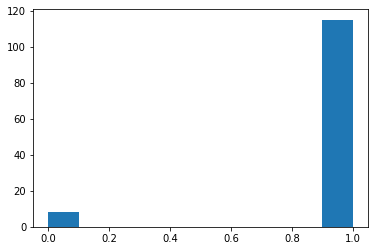

In [23]:
import matplotlib.pyplot as plt
plt.hist(switzerland_df.HeartDisease)

(array([164.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 139.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

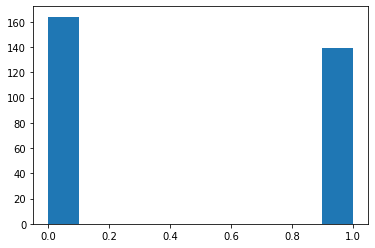

In [24]:
plt.hist(cleveland_df.HeartDisease)

In [28]:
clients = []
for i in list(df_dict.keys()):
    df = df_dict.get(i)
    df_dict[i] = new_df(df)
    location_data = new_df(df)
    y = location_data.HeartDisease
    location_data = location_data.drop(columns="HeartDisease")
    cat_feat = ['ChestPainType', 'RestingECG', 'ST_Slope']
    location_data = make_dummies(location_data, cat_feat)
    numeric_feature_names = ['Age', 'MaxHR', 'RestingBP',  'Cholesterol', 'Oldpeak']
    for j in numeric_feature_names:
        if location_data[j].std() != 0: 
            location_data[j] = (location_data[j] - location_data[j].mean()) / location_data[j].std()
    x = location_data
    client_model = copy.deepcopy(glob_model)
    lr = 3
    lr_decay = 1
    clients.append(Client(i, x, y, cat_feat, client_model, lr, torch.nn.BCELoss()))



In [29]:
validation_X_set = torch.tensor(())
validation_y_set = torch.tensor(())
for i in range(len(clients)):
    validation_X_set = torch.cat((validation_X_set, clients[i].X_test), 0)
    validation_y_set = torch.cat((validation_y_set, clients[i].y_test), 0)


In [26]:
# plt.hist(validation_y_set)

In [30]:
loss_train = []
net_best = None
best_acc = None
best_epoch = None
results = []
min_loss_client = []
glob_model = LR(n_features)
glob_model.eval()
for iter in range(50):
    loss_locals = []
    client_state_dicts = []
    for client in clients:
        client.set_state_dict(glob_model.state_dict())
        client_state_dict, loss = client.train()
        
        loss_locals.append(copy.deepcopy(loss))
        min_loss_client.append(min(loss))
        client_state_dicts.append(client_state_dict)

    enrypted_state_dicts = encrypt_state_dicts(copy.deepcopy(client_state_dicts), ctx_eval)
    averaged_encrypted_state_dict = average_state_dict(enrypted_state_dicts)
    decrypted_state_dicts = decrypt_state_dicts(averaged_encrypted_state_dict)
    glob_model.load_state_dict(decrypted_state_dicts)

    loss_avg = sum(min_loss_client) / len(min_loss_client)
    loss_train.append(loss_avg)        
        
    acc_test, loss_test =  accuracy_loss_LR(glob_model,validation_X_set, validation_y_set)

    print('Round {:3d}, Average loss {:.3f}, Test loss {:.3f}, Test accuracy: {:.2f}'.format(
        iter, loss_avg, loss_test, acc_test))


    if best_acc is None or acc_test > best_acc:
        net_best = copy.deepcopy(glob_model)
        best_acc = acc_test
        best_epoch = iter

    results.append(np.array([iter, loss_avg, loss_test, acc_test, best_acc]))
    final_results = np.array(results)
    final_results = pd.DataFrame(final_results, columns=['epoch', 'loss_avg', 'loss_test', 'acc_test', 'best_acc'])

print('Best model, iter: {}, acc: {}'.format(best_epoch, best_acc))    
    

Round   0, Average loss 0.713, Test loss 0.529, Test accuracy: 0.75
Round   1, Average loss 0.596, Test loss 0.485, Test accuracy: 0.75
Round   2, Average loss 0.549, Test loss 0.476, Test accuracy: 0.74
Round   3, Average loss 0.522, Test loss 0.467, Test accuracy: 0.74
Round   4, Average loss 0.504, Test loss 0.464, Test accuracy: 0.72
Round   5, Average loss 0.491, Test loss 0.460, Test accuracy: 0.74
Round   6, Average loss 0.481, Test loss 0.459, Test accuracy: 0.74
Round   7, Average loss 0.472, Test loss 0.458, Test accuracy: 0.75
Round   8, Average loss 0.466, Test loss 0.457, Test accuracy: 0.75
Round   9, Average loss 0.460, Test loss 0.457, Test accuracy: 0.75
Round  10, Average loss 0.455, Test loss 0.458, Test accuracy: 0.75
Round  11, Average loss 0.450, Test loss 0.458, Test accuracy: 0.75
Round  12, Average loss 0.447, Test loss 0.460, Test accuracy: 0.75
Round  13, Average loss 0.443, Test loss 0.461, Test accuracy: 0.75
Round  14, Average loss 0.440, Test loss 0.462, 

In [18]:
decrypted_state_dicts['lr.weight']

tensor([[ 0.3170,  2.6666, -0.0312,  0.5973,  1.1402, -0.1384,  2.0627,  0.5769,
         -0.7088,  1.0325, -0.5087, -0.5086, -0.4269, -1.0707,  0.2741, -0.7073,
          1.0230, -0.9730]])

In [21]:
averaged_state_dict['lr.weight']

tensor([[ 0.3118,  2.6255, -0.0302,  0.5887,  1.1231, -0.1367,  2.0303,  0.5687,
         -0.6987,  1.0165, -0.5007, -0.5003, -0.4200, -1.0533,  0.2697, -0.6958,
          1.0056, -0.9577]])

In [20]:
averaged_state_dict = average_state_dict(client_state_dicts)
for key in decrypted_state_dicts.keys():
    if key == 'lr.weight':
        Distance  = torch.cdist(decrypted_state_dicts['lr.weight'],averaged_state_dict['lr.weight'])**2
    else:
        Distance = ((decrypted_state_dicts[key]-averaged_state_dict[key])**2)
    print(Distance)


tensor([[0.0047]])
tensor([0.0006])
